## Проект_5 Рекомендательные системы_v.1_10_08_2020

In [1]:
# ======================================================================
# Кейс: Вас перевели в отдел инновационной разработки рекомендательных систем. 
# Работадель хочет увеличить средний чек продаж. Ключом к успеху будет качественные рекомендации на сайте. 
# Чем лучше вы сможете рекомендовать товар пользователю, тем чаще он будет добавлять товары в корзину. 
# Цель - точнее рекомендовать нужный товар пользователю (в нашем случае, товар с более высоким средним чеком). 
# ======================================================================
# Дано:
# имеется история оценок пользователя вместе с его отзывом на товар; 
# test.csv - набор данных, для которого вы должны сделать предсказания;
# текст рецензии - это дополнительная информация;
# оценки пользователей нормированы для бинарной классификации: 
# если оценка на продукт >= 4 - продукт понравился, иначе - продукт не понравился.
# ======================================================================
# Задачи проекта:
# 1. Разведывательный анализ данных.
# Примечание: найдите закономерности в данных, опишите их и предоставьте графическое или численное доказательство.
# 2. Делайте промежуточные выводы: Объясните, почему найденные закономерности могут оказать влияние на бизнес.
# 3. Выполните предобработку данных и сгенерируйте новые фичи (признаки).
# 4. Начните с простой модели, которая могла бы давать рекомендации к item/user. Вы вольны выбрать любую библиотеку.
# 5. Подумайте как решить проблему cold start (холодного запуска) для пользователей, которых нет в тренировочной выборке.
# 6. Работайте с отзывами как с текстовыми данными.
# 7. Не зацикливайтесь на одном решении. Пробуйте разные подходы! 
# 8. Используйте разные метрики для оценки качества модели.
# 9. В финальном отчёте укажите, как предлагаемая вами рекомендательная система отразится на показателях бизнеса, 
# а также какими метриками и почему вы бы замеряли эффективность от внедрения модели. 
# ======================================================================
# P.S.: победитель определяется по наибольшему значению RocAuc.
# ======================================================================
# ======================================================================
# Data Description:
# test.csv - набор данных, для которого вы должны сделать предсказания. 
# У каждого наобора userid, itemid есть свой id, для которого вы должны сделать предсказание.
# Исходные признаки датасета:
# overall - рейтинг, который поставил пользователь
# verified - был ли отзыв верифицирован
# reviewTime - когда был отзыв написан
# reviewerName - имя пользователя
# reviewText - текст отзыва
# summary - сжатый отзыв
# vote - количество голосований за отзыв
# style - метаданные
# image - изображение продукта
# userid - id пользователя
# itemid - id товара
# id - id для предсказания
# ======================================================================
# ======================================================================

## Импортируем необходимые библиотеки и загружаем датасеты

In [2]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from itertools import combinations
from scipy.stats import ttest_ind

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

%matplotlib inline

# Загружаем датасеты
df_train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv', low_memory = False)
df_test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv', low_memory = False)
df_sample_submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv', low_memory = False)

## Вспомогательные функции для EDA

In [3]:
# Функция для нахождения значимых различий для признака по тесту Стьюдента
def get_stat_dif(column):
    cols = df_train.loc[:, column].value_counts().index[:10]
    has_importance = False
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_train.loc[df_train.loc[:, column] == comb[0], 'rating'], 
                        df_train.loc[df_train.loc[:, column] == comb[1], 'rating']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            has_importance = True
            print('Найдены статистически значимые различия для колонки', column)
            break
    if not has_importance:
        print('Статистически значимых различий для колонки {} не найдено'.format(column))
    
# Функция для проверки на выбросы
def check_for_outliers(column, bins_number):    
    median = df_train[column].median()
    IQR = df_train[column].quantile(0.75) - df_train[column].quantile(0.25)
    perc25 = df_train[column].quantile(0.25)
    perc75 = df_train[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
          , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    df_train[column].loc[df_train[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = bins_number,label = 'IQR')
    plt.legend();

## 1. Анализ датасетов (EDA)
### Посмотрим на структуру и содержимое датасета df_train

In [4]:
df_train.head()

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


### Посмотрим на основные характеристики датасета df_train

In [5]:
print(df_train.info())
print("=" * 80)
print(df_train.isna().sum().sort_values(ascending = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB
None
image             850753
vote              739155
style             413489
r

### Посмотрим на основные характеристики датасета df_test

In [6]:
print(df_test.info())
print("=" * 80)
print(df_test.isna().sum().sort_values(ascending = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB
None
image             283597
vote              246503
style             138285
reviewerName          47
Id                     0
itemid                 0
userid                 0
unixReviewTime         0
asin                   0
reviewTime    

### Построим тепловую карту пропусков для df_train

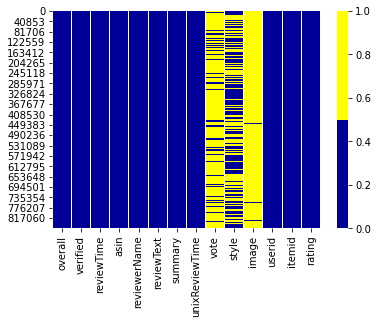

In [7]:
cols = df_train.columns[:15]
colours = ['#000099', '#ffff00'] 
sns.heatmap(df_train[cols].isnull(), cmap = sns.color_palette(colours))

Легенда к рисунку: желтый - пропущенные данные, синий - непропущенные

#### Краткие выводы №1:

В датасете df_train содержится 5 числовых, 1 булевый и 7 строковых столбцов.
Столбцы 'reviewTime' и 'unixReviewTime' - дублирующие друг друга, поэтому 'reviewTime' - позднее выбросим. 
В столбцах 'image', 'vote', 'style', 'reviewText', 'reviewerName', 'summary' - имеются пропуски.
Больше всего пропусков в столбцах 'image', 'vote', 'style'.
Пока не понятно, что нужно 'overall' или 'rating' ???????

### Построим тепловую карту пропусков для df_test

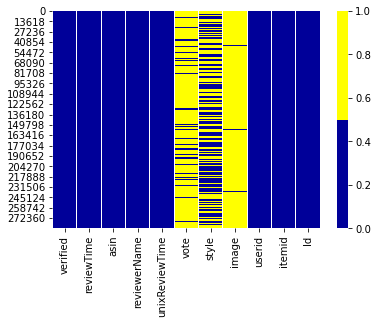

In [8]:
cols = df_test.columns[:12]
colours = ['#000099', '#ffff00'] 
sns.heatmap(df_test[cols].isnull(), cmap = sns.color_palette(colours))

Легенда к рисунку: желтый - пропущенные данные, синий - непропущенные

#### Краткие выводы №2:

В датасете df_test содержится 4 числовых, 1 булевый и 6 строковых столбцов. Столбцы 'overall', 'reviewText', 'summary' - отсутствуют. Присутствует столбец 'id'. Столбцы 'reviewTime' и 'unixReviewTime' - дублирующие друг друга, поэтому 'reviewTime' - выбросим. В столбцах 'image', 'vote', 'style', 'reviewerName' - имеются пропуски. Больше всего пропусков в столбцах 'image', 'vote', 'style'.

#### Краткие выводы №3:

Датасет 'df_train' - это набор данных по парам 'itemid-userid'.
'df_test' - это набор данных, для которых мы в итоге должны делать предсказания.
Следует отметить, что в датасете 'df_train' есть целевая переменная 'rating', которой нет в тестовом датасете 'df_test', а также столбцы 'overall', 'reviewText', 'summary' также отсутствуют в датасете 'df_test'.

!!! Следует обратить внимание на комментарий к заданию: у каждого набора userid, itemid есть свой id, для которого вы должны сделать предсказание.

## Посмотрим на каждый из столбцов по отдельности

### Смотрим на столбец 'overall'

Кол-во уникальных значений в "overall" = 5
Пропущенных значений в столбце 'overall' =  0


count    857895.000000
mean          4.441695
std           1.064655
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

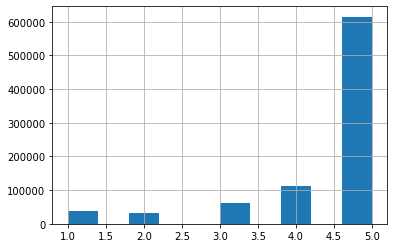

In [9]:
print('Кол-во уникальных значений в "overall" =', df_train.overall.nunique())
print("Пропущенных значений в столбце 'overall' = ", df_train['overall'].isnull().sum())
# Посмотрим на распределение числового столбца 'overall'
df_train['overall'].hist()
df_train['overall'].describe()

#### Краткие выводы №4:

Видно, что распределение - экспоненциальной формы, кол-во '5' - гораздо больше, чем остальных оценок.

!!! Есть гипотеза, что числовые значения в столбце 'overall' и текстовые оценки 'summary' - это об одном и том же.

Найдены статистически значимые различия для колонки overall
25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].


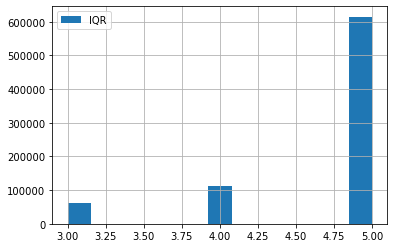

In [10]:
# Выполним нахождение значимых различий для признака 'overall' по тесту Стьюдента и проверим наличие выбросов
get_stat_dif('overall')
check_for_outliers('overall', 13)

#### Краткие выводы №5:
выбросов в столбце 'overall' нет и столбец является значимым.

### Смотрим на столбец 'verified'

кол-во уникальных значений в "verified" = 2
кол-во уникальных значений в "verified" = 2


count    285965.000000
mean          0.869351
std           0.337017
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: verified, dtype: float64

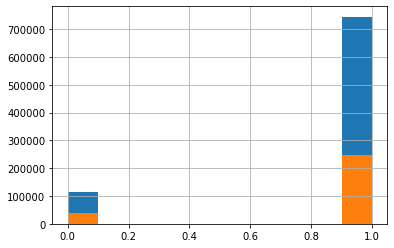

In [11]:
# Преобразуем в числовые значения признак 'verifed' в df_train
df_train['verified'] = df_train['verified'].apply(lambda x: int(1) if x else int(0))

# Посмотрим на распределение столбца 'verified' в df_train
print('кол-во уникальных значений в "verified" =', df_train.verified.nunique())
df_train['verified'].hist()
df_train['verified'].describe()

# Преобразуем в числовые значения признак 'verifed' в df_test
df_test['verified'] = df_test['verified'].apply(lambda x: int(1) if x else int(0))

# Посмотрим на распределение столбца 'verified' в df_test
print('кол-во уникальных значений в "verified" =', df_test.verified.nunique())
df_test['verified'].hist()
df_test['verified'].describe()

Видно, что верифицированных отзывов гораздо больше, чем неверифицированных отзывов

Найдены статистически значимые различия для колонки verified
25-й перцентиль: 1.0, 75-й перцентиль: 1.0, IQR: 0.0,  Границы выбросов: [1.0, 1.0].


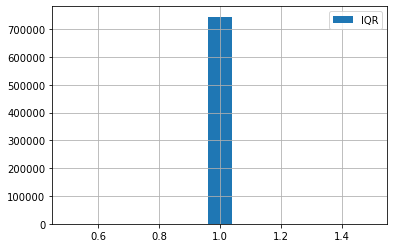

In [12]:
# Выполним нахождение значимых различий для признака 'verified' по тесту Стьюдента и проверим наличие выбросов
get_stat_dif('verified')
check_for_outliers('verified', 13)

#### Краткие выводы №6:
выбросов в столбце 'verified' нет и столбец является значимым.

### Смотрим на столбец 'asin'

In [13]:
print('кол-во уникальных значений в "asin" =', df_train.asin.nunique())
# Посмотрим на столбец 'asin' и на распределение уникальных значений
pd.DataFrame(df_train.asin.value_counts())
# pd.unique(df_train['asin']).tolist()

кол-во уникальных значений в "asin" = 41302


,asin
B00BUKL666,5491
B00D3M2QP4,4733
B008QMX2SG,4654
B00R7PWK7W,2547
B000X3TPHS,2300
...,...
B00HFVVEPW,1
B005CJUXOM,1
B001E5DY1C,1
B007WPLDCK,1


In [14]:
# Посмотрим на перечень значений, встретившихся в столбце 'asin' более 1000 раз
print("Значений, встретившихся в столбце 'asin' более 1000 раз = ", (df_train.asin.value_counts() > 1000).sum())
# Отобразим уникальные значения в столбце 'asin', которые встретились более 1000 раз
pd.DataFrame(df_train.asin.value_counts()[df_train.asin.value_counts() > 1000])

Значений, встретившихся в столбце 'asin' более 1000 раз =  25


,asin
B00BUKL666,5491
B00D3M2QP4,4733
B008QMX2SG,4654
B00R7PWK7W,2547
B000X3TPHS,2300
B000F4DKAI,2180
B0001LO3FG,2126
B00KSN9TME,1991
B000U0OUP6,1951
B000E1FZHS,1945


In [15]:
# Функция отрисовки боксплота для конкретной колонки
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x = column, y = 'rating', 
                data = df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:50])],
               ax=ax)
    plt.xticks(rotation = 45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

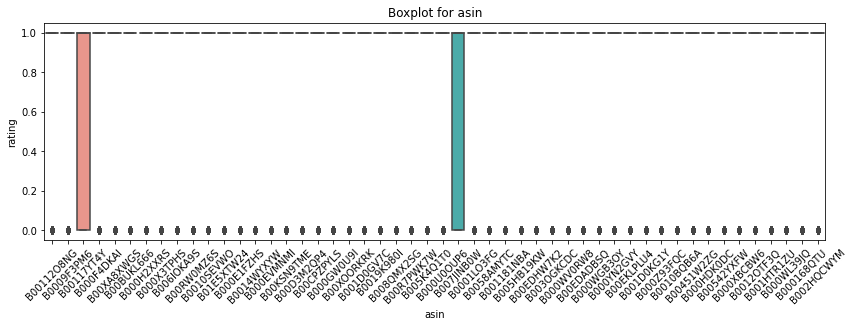

Найдены статистически значимые различия для колонки asin


In [16]:
# Выполненим построение распределения
get_boxplot('asin')
# Выполним нахождение значимых различий для признака 'asin' по тесту Стьюдента
get_stat_dif('asin')

#### Краткие выводы №7:
признак 'asin' категориальный (номинативный) и является значимым.

### Смотрим на столбец 'reviewerName'

In [17]:
print('кол-во уникальных значений в "reviewerName" =', df_train.reviewerName.nunique())
# Посмотрим на столбец 'reviewerName' и на распределение уникальных значений
pd.DataFrame(df_train.reviewerName.value_counts())

кол-во уникальных значений в "reviewerName" = 101207


,reviewerName
Amazon Customer,31726
Kindle Customer,6228
Linda,734
John,725
David,619
...,...
Rian McGonigal,1
Sharon Chen,1
shy musa,1
El Jefe,1


In [18]:
# Посмотрим на перечень значений, встретившихся в столбце 'reviewerName' более 500 раз
print("Значений, встретившихся в столбце 'reviewerName' более 500 раз = ", (df_train.reviewerName.value_counts() > 500).sum())
# Отобразим уникальные значения в столбце 'reviewerName', которые встретились более 500 раз
pd.DataFrame(df_train.reviewerName.value_counts()[df_train.reviewerName.value_counts() > 500])

Значений, встретившихся в столбце 'reviewerName' более 500 раз =  10


,reviewerName
Amazon Customer,31726
Kindle Customer,6228
Linda,734
John,725
David,619
Mary,573
Mike,565
Karen,524
Chris,523
Michael,511


In [19]:
# Выполним нахождение значимых различий для признака 'reviewerName' по тесту Стьюдента
get_stat_dif('reviewerName')

Найдены статистически значимые различия для колонки reviewerName


#### Краткие выводы №8:
признак 'reviewerName' является значимым. 

Подход №1 - можно разнести самых активных пользователей по отдельным признакам с помощью get_dummies, т.е. сделать 10 столбцов для списка самых активных пользователей и 11-й для всех остальных.
Либо подход №2 - признак 'reviewerName' удалить, а пользователей идентифицировать по id.

### Смотрим на столбец 'reviewText'

In [20]:
# столбец 'reviewText'
df_train.reviewText.head()

0    These are my FAVORITE spices in my collection....
1    Add A package to my Coffee and it makes a good...
2    I love the Torani syrups, but not the prices o...
3    Very fragrant. The price can't be beat. I do l...
4    These are my favorite jalapeno chips so far. T...
Name: reviewText, dtype: object

Пока не понятно, есть ли смысл возиться с указанным столбцом???

### Смотрим на столбец 'summary'

In [21]:
print('кол-во уникальных значений в "summary" =', df_train.summary.nunique())
# Посмотрим на столбец 'summary' и на распределение уникальных значений
pd.DataFrame(df_train.summary.value_counts())

кол-во уникальных значений в "summary" = 411451


,summary
Five Stars,173850
Four Stars,26878
Three Stars,12033
One Star,5386
Two Stars,4989
...,...
Best grain ever,1
Tastes good for dogs and humans,1
Typical Grocery Store Vinegar,1
Great Price - Good Hot Chocolate - Excellent Selection,1


In [22]:
# Посмотрим на перечень значений, встретившихся в столбце 'summary' более 500 раз
print("Значений, встретившихся в столбце 'summary' более 500 раз = ", (df_train.summary.value_counts() > 500).sum())
# Отобразим уникальные значения в столбце 'summary', которые встретились более 500 раз
pd.DataFrame(df_train.summary.value_counts()[df_train.summary.value_counts() > 500])

Значений, встретившихся в столбце 'summary' более 500 раз =  34


,summary
Five Stars,173850
Four Stars,26878
Three Stars,12033
One Star,5386
Two Stars,4989
Delicious,3463
Yummy,2858
Delicious!,2590
Great,2220
Good,2073


#### Краткие выводы №9:
Признак 'summary' категориальный (номинативный). 
Гипотеза о том, что числовые значения в столбце 'overall' и текстовые оценки 'summary' - это об одном и том же подтверждается.
Необходимо написать вспомогательную функцию, чтобы схлопнуть все популярные виды оценок в 5- или еще какую-то бальную шкалу оценок

#### Способ №1 - для схлопывания всех оценок в 5 бальную систему:

In [23]:
# Во-первых, Создадим для каждой оценки соответствующие списки
unique_summary_5 = []
unique_summary_4 = []
unique_summary_3 = []
unique_summary_2 = []
unique_summary_1 = []

# Во-вторых, Напишем вспомогательную функцию, чтобы выцепить все комментарии, которые относятся к соответствующим оценкам
# и при этом не будем тратить время на длительные по времени запросы на обработку
def add_unique_summary_from_overall(value):
    unique_list = pd.unique(df_train['summary'][df_train['overall'] == value]).tolist()
    return unique_list
    
unique_summary_5 = add_unique_summary_from_overall(5)
unique_summary_4 = add_unique_summary_from_overall(4)
unique_summary_3 = add_unique_summary_from_overall(3)
unique_summary_2 = add_unique_summary_from_overall(2)
unique_summary_1 = add_unique_summary_from_overall(1)

# В-третьих, заменим все оценки на соответствующие категориальные значения, если они встречаются в соответствующем списке
def convert_summary_from_base(value):  
    if value in unique_summary_5:
        grade = 'five'
    elif value in unique_summary_4:
        grade = 'four' 
    elif value in unique_summary_3:
        grade = 'three'
    elif value in unique_summary_2:
        grade = 'two'
    elif value in unique_summary_1:
        grade = 'one'
    return grade

# df_train['summary'] = df_train['summary'].apply(convert_summary_from_base)
# df_train['summary'].value_counts(dropna = False)

#### Способ №2 (Быстродейственный вариант) - для схлопывания всех оценок в 5 бальную систему

In [24]:
def convert_summary_from_overall(value):
    if value == 5:
         return 'five'
    elif value == 4:
         return 'four'
    elif value == 3:
         return 'three'
    elif value == 2:
         return 'two'
    elif value == 1:
        return 'one'

df_train['summary'] = df_train['overall'].apply(convert_summary_from_overall)
df_train['summary'].value_counts(dropna = False)

print('кол-во уникальных значений в "summary" =', df_train.summary.nunique())
# Посмотрим на столбец 'summary' и на распределение уникальных значений
pd.DataFrame(df_train.summary.value_counts())

кол-во уникальных значений в "summary" = 5


,summary
five,615196
four,113094
three,60440
one,37498
two,31667


In [25]:
# Выполним нахождение значимых различий для признака 'summary' по тесту Стьюдента
get_stat_dif('summary')

Найдены статистически значимые различия для колонки summary


#### Краткие выводы №10:
Признак 'summary' категориальный (номинативный) и является значимым. 

### Смотрим на столбец 'unixReviewTime'

кол-во уникальных значений в "unixReviewTime" = 4580


count    8.578950e+05
mean     1.441755e+09
std      5.973571e+07
min      9.657792e+08
25%      1.411949e+09
50%      1.449101e+09
75%      1.484870e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64

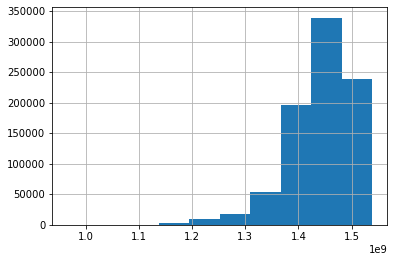

In [26]:
print('кол-во уникальных значений в "unixReviewTime" =', df_train.unixReviewTime.nunique())
# Посмотрим на распределение числового столбца 'unixReviewTime'
df_train['unixReviewTime'].hist()
df_train['unixReviewTime'].describe()

Видно, что распределение - экспоненциальной формы

Статистически значимых различий для колонки unixReviewTime не найдено
25-й перцентиль: 1411948800.0, 75-й перцентиль: 1484870400.0, IQR: 72921600.0,  Границы выбросов: [1302566400.0, 1594252800.0].


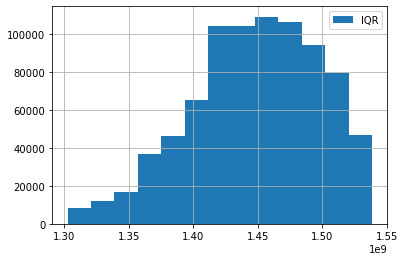

In [27]:
# Выполним нахождение значимых различий для признака 'unixReviewTime' по тесту Стьюдента и проверим наличие выбросов
get_stat_dif('unixReviewTime')
check_for_outliers('unixReviewTime', 13)

#### Краткие выводы №11:
Можно сделать вывод, что данный признак не является значимым для рейтинга, но, возможно, признак понадобится при формировании разряжённых матриц.

### Смотрим на столбец 'vote'

Пропущенных значений в столбце 'vote' =  0
Пропущенных значений в столбце 'vote' =  0


count    285965.000000
mean          0.137996
std           0.344896
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: vote, dtype: float64

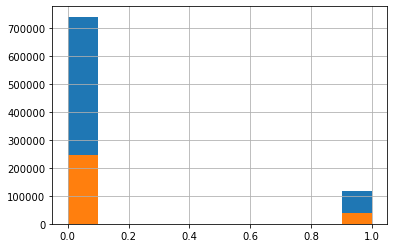

In [28]:
# Избавимся от символа 'запятая'
df_train['vote'] = df_train['vote'].apply(lambda x: int(x.replace(',', '')) if x != None and type(x) == str else x)
df_test['vote'] = df_test['vote'].apply(lambda x: int(x.replace(',', '')) if x != None and type(x) == str else x)

# Преобразуем значения в столбце 'vote' в тип бинарные: 1 - есть голос за отзыв; 0 - нет отзыва за голос
df_train['vote'] = df_train['vote'].apply(lambda x: int(1) if x > 0 else int(0))
df_test['vote'] = df_test['vote'].apply(lambda x: int(1) if x > 0 else int(0))

print("Пропущенных значений в столбце 'vote' = ", df_train['vote'].isnull().sum())
print("Пропущенных значений в столбце 'vote' = ", df_test['vote'].isnull().sum())

# Посмотрим на распределение числового столбца 'vote'
df_train['vote'].hist()
df_train['vote'].describe()
df_test['vote'].hist()
df_test['vote'].describe()

Найдены статистически значимые различия для колонки vote
25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


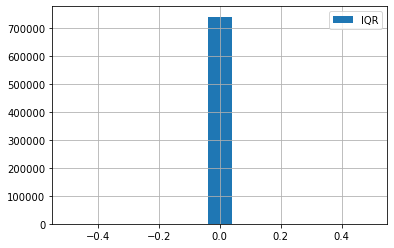

In [29]:
# Выполним нахождение значимых различий для признака 'vote' по тесту Стьюдента и проверим наличие выбросов
get_stat_dif('vote')
check_for_outliers('vote', 13)

#### Краткие выводы №12:
выбросов в столбце 'vote' нет и столбец является значимым.

### Смотрим на столбец 'style'

In [30]:
# print('кол-во уникальных значений в "style" =', df_train.style.nunique())
print("Пропущенных значений в столбце 'style' = ", df_train['style'].isnull().sum())

# Посмотрим на столбец 'style' и на список уникальных значений
pd.unique(df_train['style']).tolist()

Пропущенных значений в столбце 'style' =  413489


[nan,
 "{'Size:': ' 60-0.73 oz Envelopes'}",
 "{'Flavor:': ' Jalapeo'}",
 "{'Size:': ' Pack of 6', 'Flavor:': ' Organic Spearmint'}",
 "{'Size:': ' 16 Ounce (Pack of 6)', 'Flavor:': ' Coconut Sugar'}",
 "{'Size:': ' 12 ounce', 'Flavor:': ' Gourmet Chocolate'}",
 "{'Flavor:': ' Simply Detox'}",
 "{'Size:': ' 8 Oz Raw'}",
 "{'Size:': ' 8 Ounce'}",
 "{'Size:': ' 16 Ounce'}",
 "{'Flavor:': ' Lemon Lime'}",
 "{'Size:': ' 18 Count (Pack of 6)'}",
 "{'Size:': ' 750 ml'}",
 "{'Size:': ' 1 Pack'}",
 "{'Size:': ' 20 Count (Pack of 6)', 'Flavor:': ' Earl Grey'}",
 "{'Flavor:': ' Strawberry'}",
 "{'Size:': ' 40 Count', 'Flavor:': ' Mega Coffee'}",
 "{'Size:': ' 2.85 Ounce (Pack of 6)'}",
 "{'Size:': ' 32 Ounce', 'Flavor:': ' Black'}",
 "{'Size:': ' 90 caps'}",
 "{'Color:': ' South African Rooibos'}",
 "{'Size:': ' 42 Ounce'}",
 "{'Flavor:': ' Blue Corn'}",
 "{'Flavor:': ' Ginger'}",
 "{'Package Type:': ' Standard Packaging'}",
 "{'Size:': ' 32 Ounce (Pack of 4)'}",
 "{'Size:': ' 22 oz', 'Flavor:':

#### Краткие выводы №13:
Столбец 'style' представляет собой словарь: имеется ключ и значение.
Нужно сделать отдельные столбцы 'Size', 'Flavor', 'Color' и т.д., и заполнить их соответствующими значениями - 1 и 0.

При этом столбец 'style' в обоих датасетах потом нужно удалить.

In [31]:
import ast
style_unique = []

# Сделаем список уникальных стилей
def get_unique_styles(value):
    if value == value: # отсекаем значения NaN
        value = ast.literal_eval(value) # для преобразования строки в словарь
        for key in value.keys():
            if key not in style_unique:
                style_unique.append(key)
                
df_train['style'].apply(get_unique_styles)

# Отобразим список уникальных ключей словаря
print(style_unique)

['Size:', 'Flavor:', 'Color:', 'Package Type:', 'Style:', 'Package Quantity:', 'Style Name:', 'Flavor Name:', 'Number of Items:', 'Format:', 'Unit Count:', 'Scent Name:', 'Design:', 'Product Packaging:', 'Edition:', 'Item Display Weight:', 'Size Name:', 'Item Package Quantity:']


In [32]:
# Сделаем список уникальных колонок и словарь сопоставлений уникальных значений style этим колонкам
style_columns = ['size', 'flavor', 'color', 'package_type', 'item_style', 'package_quantity', 'items_number', 'format',
                 'design', 'product_packaging', 'edition', 'item_weight']

style_dict = {'Size:': 'size', 'Flavor:':'flavor', 'Color:':'color', 'Package Type:':'package_type', 
              'Style:':'item_style', 'Package Quantity:':'package_quantity', 'Style Name:':'item_style', 
              'Flavor Name:':'flavor', 'Number of Items:':'items_number', 'Format:':'format', 
              'Unit Count:':'items_number', 'Scent Name:':'flavor', 'Design:':'design', 
              'Product Packaging:':'product_packaging', 'Edition:':'edition', 
              'Item Display Weight:':'item_weight', 'Size Name:':'size', 'Item Package Quantity:':'package_quantity'}

# Напишем функцию, которая будет возвращать значение '1' или '0' для текущей колонки
def get_style_column(value):
    if value != value or pd.isnull(value) or value == 'nan':
        #return None
        return 0
    
    value = ast.literal_eval(value)
    for key in value.keys():
        if style_dict[key] == column:
            #return value[key]
            return 1
    #return None
    return 0

for column in style_columns:
    df_train[column] = df_train['style'].apply(get_style_column)
    df_test[column] = df_test['style'].apply(get_style_column)

#### Краткие выводы №14:

Добавлены новые признаки 'size', 'flavor', 'color', 'package_type', 'package_quantity', 'format', 'item_style', 'items_number', 'design', 'product_packaging', 'edition', 'item_weight'. Тест Стюдента над ними выполним чуть позднее.

### Смотрим на столбец 'image'

In [33]:
print("Всего строк в столбце 'image' =", len(df_train['image']))
print("Пропущенных значений в столбце 'image' = ", df_train['image'].isnull().sum())
get_stat_dif('image')

Всего строк в столбце 'image' = 857895
Пропущенных значений в столбце 'image' =  850753
Найдены статистически значимые различия для колонки image


#### Краткие выводы №15:
столбец 'image' следует либо удалить, либо заполнить бинарными значениями: 1 - картинка есть, 0 - картинки нет.

Сделаем пока второй вариант.

count    285965.000000
mean          0.008281
std           0.090621
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: image, dtype: float64

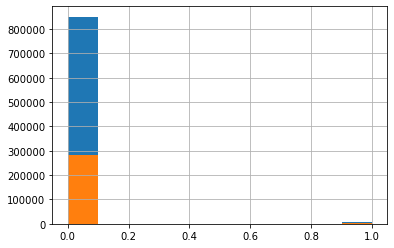

In [34]:
# Напишем функцию, которая будет возвращать значение '1' или '0' для колонки image
def get_convert_image(value):
    if value != value or pd.isnull(value) or value == 'nan':
        return 0   
    return 1

df_train['image'] = df_train['image'].apply(get_convert_image)
df_test['image'] = df_test['image'].apply(get_convert_image)

# Посмотрим на распределение числового столбца 'image'
df_train['image'].hist()
df_train['image'].describe()

df_test['image'].hist()
df_test['image'].describe()

#### Краткие выводы №16:
столбец 'image' является значимым.

### Смотрим на столбец 'userid'

Кол-во уникальных значений в "userid" = 127448
Пропущенных значений в столбце 'userid' =  0
Найдены статистически значимые различия для колонки userid


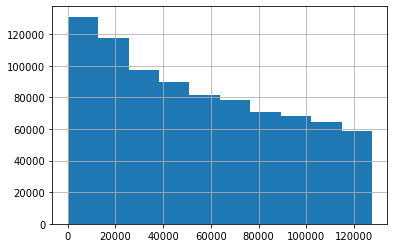

In [35]:
print('Кол-во уникальных значений в "userid" =', df_train.userid.nunique())
print("Пропущенных значений в столбце 'userid' = ", df_train['userid'].isnull().sum())
# Посмотрим на распределение числового столбца 'userid'
df_train['userid'].hist()
df_train['userid'].describe()
# Выполним нахождение значимых различий для признака 'userid' по тесту Стьюдента и проверим наличие выбросов
get_stat_dif('userid')

#### Краткие выводы №17:
столбец 'userid' является значимым.

### Смотрим на столбец 'itemid'

Кол-во уникальных значений в "itemid" = 41302
Пропущенных значений в столбце 'itemid' =  0
Найдены статистически значимые различия для колонки itemid


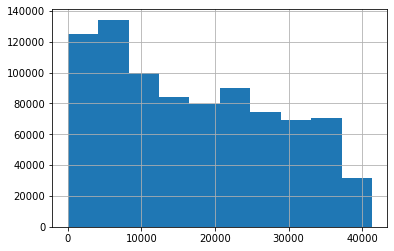

In [36]:
print('Кол-во уникальных значений в "itemid" =', df_train.itemid.nunique())
print("Пропущенных значений в столбце 'itemid' = ", df_train['itemid'].isnull().sum())
# Посмотрим на распределение числового столбца 'itemid'
df_train['itemid'].hist()
df_train['itemid'].describe()
# Выполним нахождение значимых различий для признака 'itemid' по тесту Стьюдента и проверим наличие выбросов
get_stat_dif('itemid')

#### Краткие выводы №18:
столбец 'itemid' является значимым.

### Смотрим на столбец 'rating'

Кол-во уникальных значений в "rating" = 2


count    857895.000000
mean          0.848927
std           0.358120
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64

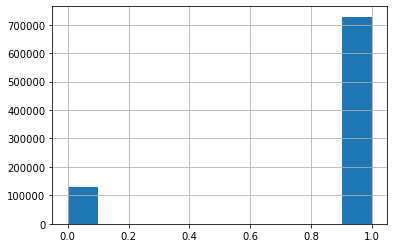

In [37]:
print('Кол-во уникальных значений в "rating" =', df_train.rating.nunique())
# Посмотрим на распределение числового столбца 'userid'
df_train['rating'].hist()
df_train['rating'].describe()

Найдены статистически значимые различия для колонки rating
25-й перцентиль: 1.0, 75-й перцентиль: 1.0, IQR: 0.0,  Границы выбросов: [1.0, 1.0].


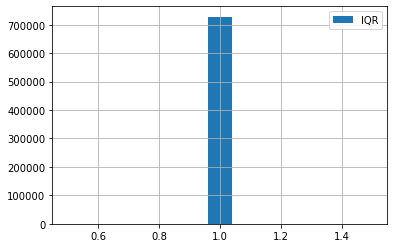

In [38]:
# Выполним нахождение значимых различий для признака 'rating' по тесту Стьюдента и проверим наличие выбросов
get_stat_dif('rating')
check_for_outliers('rating', 13)

#### Краткие выводы №19:
столбец 'rating' не содержит выбросов.

## 2. Корреляционный анализ

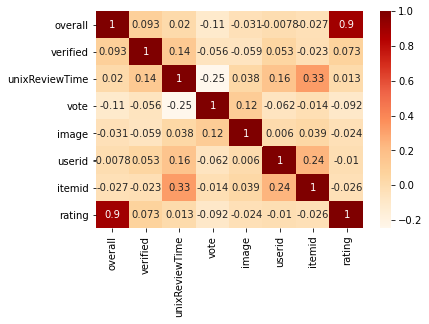

In [39]:
# Посмотрим корреляцию числовых признаков в датасете df_train
def heatmap(x, y, dataframe):
    sns.heatmap(dataframe.corr(), cmap = "OrRd", annot = True)
    plt.show()
    
dimension_col_list = ['overall', 'verified', 'unixReviewTime', 'vote', 'image', 'userid', 'itemid', 'rating']

heatmap(10, 10, df_train.filter(dimension_col_list))

In [40]:
# Используем для наглядности матрицу корреляций:
df_train.filter(dimension_col_list).corr()

,overall,verified,unixReviewTime,vote,image,userid,itemid,rating
overall,1.000000,0.093266,0.019756,-0.110396,-0.031300,-0.007821,-0.027214,0.897339
verified,0.093266,1.000000,0.135209,-0.056168,-0.058920,0.052519,-0.023189,0.072735
unixReviewTime,0.019756,0.135209,1.000000,-0.247651,0.037567,0.161879,0.325628,0.013242
vote,-0.110396,-0.056168,-0.247651,1.000000,0.115294,-0.062212,-0.014077,-0.092243
image,-0.031300,-0.058920,0.037567,0.115294,1.000000,0.005969,0.039109,-0.024003
userid,-0.007821,0.052519,0.161879,-0.062212,0.005969,1.000000,0.241030,-0.010240
itemid,-0.027214,-0.023189,0.325628,-0.014077,0.039109,0.241030,1.000000,-0.026425
rating,0.897339,0.072735,0.013242,-0.092243,-0.024003,-0.010240,-0.026425,1.000000


### Анализ номинативных переменных

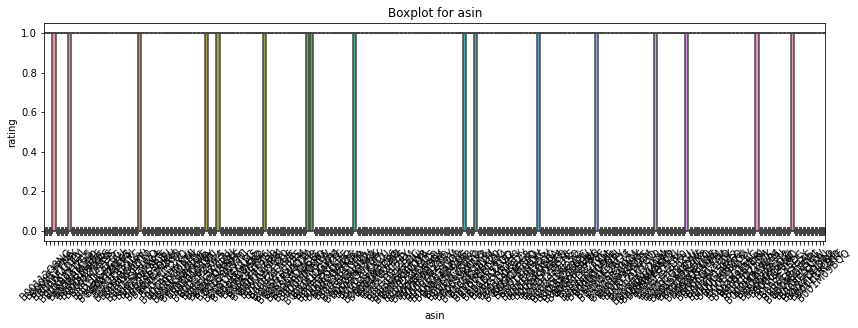

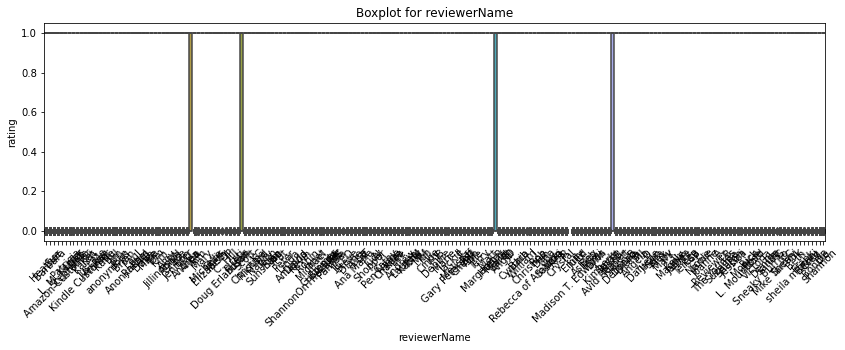

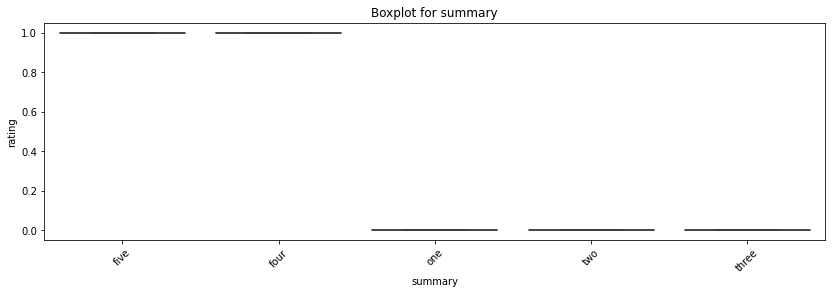

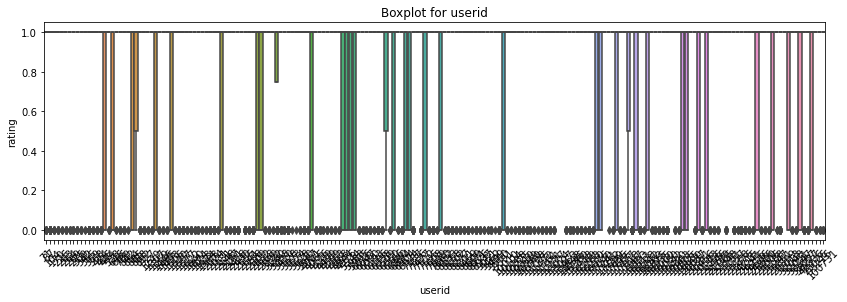

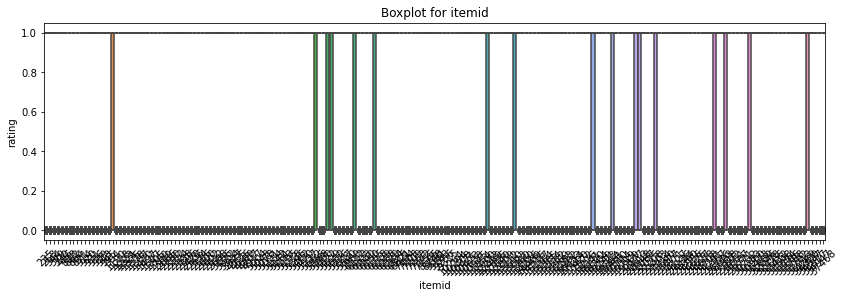

In [41]:
# Номинативные переменные, которые осталось рассмотреть: asin, reviewerName, summary.

# Так как уникальных значений в столбцах достаточно много, будем брать в рассмотрение по, например, 200 самых частотных.
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x = column, y = 'rating', 
                data = df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:200])],
               ax = ax)
    plt.xticks(rotation = 45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in ['asin', 'reviewerName', 'summary', 'userid', 'itemid']:
    get_boxplot(col)

### Тест Стьюдента

In [42]:
# Прогоним столбцы на тест Стьюдента
col_list = ['verified', 'asin', 'reviewerName', 'unixReviewTime', 'vote', 'image', 'userid', 'itemid',
           'size', 'flavor', 'color', 'package_type', 'item_style', 'package_quantity', 'items_number', 'format',
            'design', 'product_packaging', 'edition', 'item_weight']

for col in col_list:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки verified
Найдены статистически значимые различия для колонки asin
Найдены статистически значимые различия для колонки reviewerName
Статистически значимых различий для колонки unixReviewTime не найдено
Найдены статистически значимые различия для колонки vote
Найдены статистически значимые различия для колонки image
Найдены статистически значимые различия для колонки userid
Найдены статистически значимые различия для колонки itemid
Найдены статистически значимые различия для колонки size
Найдены статистически значимые различия для колонки flavor
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки package_type
Статистически значимых различий для колонки item_style не найдено
Найдены статистически значимые различия для колонки package_quantity
Статистически значимых различий для колонки items_number не найдено
Найдены статистически значимые различия для колонки format
Статистически

#### Краткие выводы №20:

Так как переменные overall и rating скоррелированы почти полностью, одну переменную можно исключить. 
Пусть это будет переменная overall.
Переменные itemid и unixReviewTime - слабо скоррелированы.

Столбцы 'size', 'flavor', 'color', 'package_type', 'package_quantity', 'format' - являются значимыми.

Столбцы 'item_style', 'items_number', 'design', 'product_packaging', 'edition', 'item_weight' - не являются значимыми. Незначимые столбцы можно затем удалить.

В итоге необходимо удалить следующие признаки: overall, reviewTime, reviewText(?), unixReviewTime, style, item_style, items_number, design, product_packaging, edition, item_weight.

### Удаление лишних столбцов из датасетов df_train и df_test

In [43]:
# Удаление столбцов из датасета df_train
# df_train.drop('overall', axis = 1, inplace = True)
df_train.drop('reviewTime', axis = 1, inplace = True)
df_train.drop('reviewText', axis = 1, inplace = True)
# df_train.drop('summary', axis = 1, inplace = True)
# df_train.drop('unixReviewTime', axis = 1, inplace = True)
df_train.drop('style', axis = 1, inplace = True)

df_train.drop('item_style', axis = 1, inplace = True)
df_train.drop('items_number', axis = 1, inplace = True)
df_train.drop('design', axis = 1, inplace = True)
df_train.drop('product_packaging', axis = 1, inplace = True)
df_train.drop('edition', axis = 1, inplace = True)
df_train.drop('item_weight', axis = 1, inplace = True)

# Удаление столбцов из датасета df_test
df_test.drop('reviewTime', axis = 1, inplace = True)
# df_test.drop('unixReviewTime', axis = 1, inplace = True)
df_test.drop('style', axis = 1, inplace = True)
df_test.drop('Id', axis = 1, inplace = True)

df_test.drop('item_style', axis = 1, inplace = True)
df_test.drop('items_number', axis = 1, inplace = True)
df_test.drop('design', axis = 1, inplace = True)
df_test.drop('product_packaging', axis = 1, inplace = True)
df_test.drop('edition', axis = 1, inplace = True)
df_test.drop('item_weight', axis = 1, inplace = True)

df_train.head(4)

,overall,verified,asin,reviewerName,summary,unixReviewTime,vote,image,userid,itemid,rating,size,flavor,color,package_type,package_quantity,format
0,5.0,1,B01CPNIEQG,Heather,five,1475539200,0,0,102179,37138,1.0,0,0,0,0,0,0
1,5.0,1,B006F63M8U,Linda Odom,five,1456790400,0,0,3625,17322,1.0,1,0,0,0,0,0
2,5.0,1,B00112O8NG,DesertBlossom,five,1466899200,1,0,39495,5600,1.0,0,0,0,0,0,0
3,5.0,1,B00MRAQUM8,Connie L. Reaves,five,1378339200,0,0,72854,30249,1.0,0,0,0,0,0,0


In [44]:
df_test.head(4)

,verified,asin,reviewerName,unixReviewTime,vote,image,userid,itemid,size,flavor,color,package_type,package_quantity,format
0,1,B001E5E3X0,Rudys Mom,1475280000,0,0,68877,7506,0,0,0,0,0,0
1,1,B005BYXX5E,pharg,1404000000,1,0,50442,15530,0,0,0,0,0,0
2,1,B0052OK6OO,dhalex,1431993600,0,0,64349,15049,0,0,0,0,0,0
3,1,B003SO8HGE,Vanessa,1412467200,0,0,26206,11957,0,1,0,0,0,0


## 3. Создание датасета с информацией по продуктам

#### Примечание: В данном разделе поработаем с файлом 'meta_Grocery_and_Gourmet_Food.json', чтобы сформировать матрицу признаков товаров (item_features)

In [45]:
import json

meta_file = []
with open('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json', 'r') as in_file:
    for line in in_file:
        meta_file.append(json.loads(line))

In [46]:
# посмотрим, что представляет из себя файл 'meta_Grocery_and_Gourmet_Food.json': отобразим несколько первых строчек
print(meta_file[:3])
print('='*80)
# отобразим тип, размер, тип первого элемента
print(type(meta_file), len(meta_file), type(meta_file[0]))

[{'category': ['Grocery & Gourmet Food', 'Dairy, Cheese & Eggs', 'Cheese', 'Gouda'], 'description': ['BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.'], 'title': 'Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs', 'brand': 'Ariola Imports', 'rank': '165,181inGroceryGourmetFood(', 'also_view': ['B0000D9MYM', 'B0000D9MYL', 'B00ADHIGBA', 'B00H9OX598', 'B001LM42GY', 'B001LM5TDY'], 'main_cat': 'Grocery', 'price': '$41.91', 'asin': '0681727810'}, {'category': ['Grocery & Gourmet Food', 'Cooking & Baking', 'Sugar Substitutes', 'Xylitol'], 'description': ['Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science Publishers ltd', 'Statements regarding dietary supplements have not been evaluated by the FDA and are not intended to diagnose, treat, cure, or prevent any disease or health condition.']

#### Краткие выводы №21:

Файл 'meta_file' - представляет собой список словарей, описывающих продукты. 
Содержит следующие ключи: 'category', 'description', 'title', 'brand', 'rank' и т.д.
Необходимо построить из 'meta_file' датафрейм с признаками товаров.

In [47]:
# Создадим новый датафрейм 'df_items'
# df_items = pd.DataFrame()

# Создадим новые признаки:
df_items = df_train[['itemid', 'unixReviewTime']].groupby('itemid').count() # кол-во отзывов на товар
df_items['asin'] = df_train[['itemid', 'asin']].groupby('itemid').first()
df_items['item_id'] = df_items.index
df_items['overall_mean'] = df_train[['itemid', 'overall']].groupby('itemid').mean() # средняя оценка каждого товара
df_items.columns = ['col_count', 'asin', 'item_id', 'overall_mean']

df_items.head(5)

,col_count,asin,item_id,overall_mean
itemid,,,,
0,8,4639725183,0,4.875000
1,21,4639725043,1,4.190476
2,7,5463213682,2,4.857143
3,74,9742356831,3,4.581081
4,10,B00004S1C5,4,4.400000


In [48]:
# Вернём значение 'brand' для каждого товара
def get_brand(asin):
    for elem in meta_file:
        if elem.get('asin') == asin:
            return elem.get('brand')
    return('None')

# Вернём последнюю запись 'category' для каждого товара
def get_category(asin):
    for elem in meta_file:
        if elem.get('asin') == asin:
            return elem.get('category')[-1]
    return('None')

# Вернём значение 'title' для каждого товара
def get_title(asin):
    for elem in meta_file:
        if elem.get('asin') == asin:
            return elem.get('title')
    return('None')

# Вернём значение 'main_cat' для каждого товара
def get_main_cat(asin):
    for elem in meta_file:
        if elem.get('asin') == asin:
            return elem.get('main_cat')
    return('None')

# Вернём значение 'price' для каждого товара
def get_price(asin):
    for elem in meta_file:
        if elem.get('asin') == asin:
            return elem.get('price')
    return('None')

In [49]:
df_items['brand'] = df_items['asin'].apply(get_brand)

In [50]:
df_items['category'] = df_items['asin'].apply(get_category)

In [51]:
df_items['title'] = df_items['asin'].apply(get_title)

In [52]:
df_items['main_cat'] = df_items['asin'].apply(get_main_cat)

In [53]:
df_items['price'] = df_items['asin'].apply(get_price)

In [54]:
# df_items['brand'] = df_items['asin'].apply(get_brand)
# df_items['category'] = df_items['asin'].apply(get_category)
# df_items['title'] = df_items['asin'].apply(get_title)
# df_items['main_cat'] = df_items['asin'].apply(get_main_cat)
# df_items['price'] = df_items['asin'].apply(get_price)

df_items.head(5)

,col_count,asin,item_id,overall_mean,brand,category,title,main_cat,price
itemid,,,,,,,,,
0,8,4639725183,0,4.875000,Lipton,Black,Lipton Yellow Label Finest Blend Tea Bags 100 ...,Grocery,$12.98
1,21,4639725043,1,4.190476,Lipton,Black,Lipton Yellow Label Tea (loose tea) - 450g,Grocery,$12.46
2,7,5463213682,2,4.857143,Organo Gold,Coffee,Organo Gold Cafe Supreme 100% Certified Ganode...,Grocery,$29.90
3,74,9742356831,3,4.581081,Mae Ploy,Curry Sauce,"Mae Ploy Green Curry Paste, 14 oz",Grocery,None
4,10,B00004S1C5,4,4.400000,Harold Import Company,Food Coloring,"Ateco Food Coloring Kit, 6 colors",Amazon Home,None


In [55]:
# Удалим символ доллара из столбца 'price'
df_items['price'] = df_items['price'].apply(lambda x: x.replace('$', '') if x != None else x)

## 4. Построение рекомендательной системы

In [56]:
# Выполним импорт библиотек для построения модели
import scipy.sparse as sparse
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse

# Создадим словарь, с помощью которого по id мы сможем находить категорию товара
set_category = set(df_items['category'].unique())
print(f'всего категорий: {len(set_category)}')

mapper = dict(zip(set_category, range(len(set_category))))
df_items['id_cat'] = df_items['category'].apply(lambda x: mapper[x])

# Удалим дублирующиеся отзывы, т.к. при построении разреженной матрицы значения рейтингов складываются. 
df_train.drop_duplicates(subset = ['userid', 'itemid'], keep = 'last', inplace = True)

всего категорий: 967


In [57]:
# Построим разреженную матрицу взаимодействий
ratings_coo = sparse.coo_matrix((df_train['rating'].astype(int),
                                 (df_train['userid'], df_train['itemid'])))

train_rating_coo, test_rating_coo = random_train_test_split(ratings_coo)

In [58]:
# Приведем col_count к шкале от 0 до 5, чтобы сделать соразмерным оценке Overall
df_items['col_count'] = 5 * df_items['col_count'] / df_items['col_count'].max()

# Построим разреженную матрицу признаков по товарам. Используем следующие данные:
# 1 Категорию продукта (последнее значение в категориях продукта из файла meta
# 2 Общее количество отзывов на каждый продукт
# 3 Средняя оценка по 5-ти балльной шкале

# Обработка признаков товаров
def item_feats_to_sparse(df_items_):
    N_items = df_items_['item_id'].max() + 1
    N_cat = df_items_['id_cat'].max() + 1
    
    # данные, которые будут храниться в разреженной матрице:
    # 1 - категории (передаем единицы, которые будут соответствовать столбцу с номером категории)
    # 2 - col_count - количеcтво отзывов на товар
    # 3 - overall_mean -средняя оценка по 5-ти балльной шкале    
    data = np.concatenate([np.array([1] * len(df_items_)), df_items_.col_count.values, df_items_.overall_mean.values])
    
    # номера строк - повторим трижды список itemid
    rows_ids = np.tile(df_items_['item_id'], 3)
    
    # номера колонок: 1-номер категории; 2 - одна колонка, номер = макс. категорией + 1; 3 - одна колонка, номер = макс. категорией + 2
    col1 = df_items_['id_cat'].values
    col2 = np.array([N_cat + 1] * len(df_items_))
    col3 = np.array([N_cat + 2] * len(df_items_))
    cols_ids = np.concatenate((col1, col2, col3))
    
    return sparse.coo_matrix((data, (rows_ids, cols_ids)))
    
item_features = item_feats_to_sparse(df_items)

In [59]:
# ====================================================
# Этап. Обучение модели №1
# ====================================================

NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 35 #число параметров вектора 
NUM_EPOCHS = 10 #число эпох обучения

# Создаём модель
model = LightFM(learning_rate = 0.1, loss = 'logistic', no_components = NUM_COMPONENTS)
# Обучаем модель
model = model.fit(train_rating_coo, epochs = NUM_EPOCHS, num_threads = NUM_THREADS)

# Сделаем предсказание на тестовой выборке
preds = model.predict(test_rating_coo.row, test_rating_coo.col)
# RocAuc из sklern
sklearn.metrics.roc_auc_score(test_rating_coo.data, preds)

0.7269779765521703

In [60]:
# Посмотрим на метрику из LighfFM:
auc_LFM = auc_score(model = model, test_interactions = test_rating_coo)
auc_LFM.max(), auc_LFM.min(), auc_LFM.mean()

(1.0, 0.0, 0.7194595)

In [61]:
# Посчитаем precision, recall
pr_at_k = precision_at_k(model = model, test_interactions = test_rating_coo, k = 5)
rc_at_k = recall_at_k(model = model, test_interactions = test_rating_coo, k = 5)
print(f'Precision: {pr_at_k.mean()}, recall: {rc_at_k.mean()}')

Precision: 0.013320311903953552, recall: 0.0412643483801288


In [62]:
# ====================================================
# Этап. Обучение модели №2 на всех имеющихся данных
# ====================================================

# Создаём модель №2
model_full = LightFM(learning_rate = 0.1, loss='logistic', no_components = NUM_COMPONENTS)
# Обучаем модель №2
model_full = model_full.fit(ratings_coo, epochs = NUM_EPOCHS, num_threads = NUM_THREADS)
# Сделаем предсказание
preds_full = model_full.predict(df_test.userid.values, df_test.itemid.values)

preds_full = (preds_full - preds_full.min())/(preds_full.max() - preds_full.min())

In [63]:
# Посмотрим на метрику из LighfFM:
auc_LFM = auc_score(model = model_full, test_interactions = ratings_coo)
auc_LFM.max(), auc_LFM.min(), auc_LFM.mean()

(1.0, 0.0, 0.72081155)

In [64]:
# Посчитаем precision, recall
pr_at_k = precision_at_k(model = model_full, test_interactions = ratings_coo, k = 5)
rc_at_k = recall_at_k(model = model_full, test_interactions = ratings_coo, k = 5)
print(f'Precision: {pr_at_k.mean()}, recall: {rc_at_k.mean()}')

Precision: 0.06874018907546997, recall: 0.06536047251853062


In [65]:
preds_full = (preds_full - preds_full.min())/(preds_full.max() - preds_full.min())

df_sample_submission['rating'] = preds_full

In [66]:
# ====================================================
# Этап. Обучение модели №3 (модель с регуляриацией, полная)
# ====================================================
# Создаём модель №3 с регуляриацией 
model_full_regul = LightFM(learning_rate = 0.1, loss = 'logistic', no_components = NUM_COMPONENTS, item_alpha = 0.00001, user_alpha = 0.00001)
#Обучаем модель №3
model_full_regul = model_full_regul.fit(ratings_coo, epochs = NUM_EPOCHS, num_threads = NUM_THREADS, item_features = item_features)
#  Сделаем предсказание №3
preds_full = model_full_regul.predict(df_test.userid.values, df_test.itemid.values, item_features = item_features)

In [67]:
preds_full = (preds_full - preds_full.min())/(preds_full.max() - preds_full.min())

df_sample_submission['rating'] = preds_full

#### Краткие выводы №22:
Модели работают и вычислены метрики RocAuc, Precision, Recall.

## 5. Рекомендации для пользователей

In [68]:
# Создадим для прототипа сокращенный тренировочный набор:
df_train_reduced = df_train[['userid', 'itemid', 'overall', 'unixReviewTime']]
df_train_reduced.head()

,userid,itemid,overall,unixReviewTime
0,102179,37138,5.0,1475539200
1,3625,17322,5.0,1456790400
2,39495,5600,5.0,1466899200
3,72854,30249,5.0,1378339200
4,74859,4349,5.0,1473811200


In [69]:
N_last = 3 # кол-во последних покупок 
user_id_for_recommend = 3625 #  ID пользователя, для которого будем давать рекомендации

# Получим эмбеддинги и запишем их в файл
item_biases, item_embeddings = model_full_regul.get_item_representations(features = item_features)
user_biases, user_embeddings = model_full_regul.get_user_representations()
user_embeddings.max(), item_embeddings.max()

(0.5256374, 16.21013)

In [74]:
# !pip install nmslib

     |████████████████████████████████| 13.0 MB 3.5 MB/s eta 0:00:01


In [72]:
# !pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 191 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [75]:
import nmslib
 
# Создаём граф для поиска
nms_idx = nmslib.init(method = 'hnsw', space = 'cosinesimil')
 
# Добавляем товары в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress = True)

# Вспомогательная функция для поиска по графу
def nearest_item_nms(item_id, index, n = 3):
    nn = index.knnQuery(item_embeddings[item_id], k = n)
    return nn

In [76]:
items_recommend_ids = set()
if user_id_for_recommend in df_train_reduced['userid'].unique():
    
    # Выводим весь список покупок для этого пользователя
    df_train_reduced[df_train_reduced['userid'] == user_id_for_recommend]
    # Список трех последних покупок, оцененных на макс оценку
    last_best_items = df_train_reduced[df_train_reduced['userid'] == user_id_for_recommend
                               ].sort_values(by = ['overall', 'unixReviewTime'], 
                               ascending=False)['itemid'].values[:N_last]
    print(f'Для пользователя, который с нами давно:')
    for item_id in last_best_items:
        print(df_items[df_items['item_id'] == item_id].title)

    # составляем список рекомендаций к последним покупкам
    for item in last_best_items:
        items_recommend_ids.update(nearest_item_nms(item, nms_idx)[0])
else:
    # новым пользователям предложим случайные 5 товаров из числа тех, которые получили оценки 4 и 5 
    # и количество отзывов на них в верхних 20%    
    print("Для нового пользователя:")
    most_popular_items = df_items[(df_items['NoRev'] >= df_items['NoRev'].quantile(0.95))]
    items_recommend_ids.update(most_popular_items.sample(5)['itemid'].values)
 
print('='*80)
print('Рекомендуемые товары:')
print(items_recommend_ids)
for item_id in items_recommend_ids:
    print (df_items[df_items.index == item_id].title)

Для пользователя, который с нами давно:
itemid
17322    Milk Chocolate Swiss Miss Hot Cocoa Mix 60-0.7...
Name: title, dtype: object
itemid
8527    Folgers Coffee, Classic(Medium) Roast, 48 Ounce
Name: title, dtype: object
itemid
22230    Cheez-It Baked Snack Mix, Double Cheese, 9.75 ...
Name: title, dtype: object
Рекомендуемые товары:
{2513, 6564, 2398}
Series([], Name: title, dtype: object)
Series([], Name: title, dtype: object)
Series([], Name: title, dtype: object)


#### Краткие выводы №22:

Существующим пользователям лучше давать рекомендации на основе предыдущих покупок, а новым - наиболее популярные товары.